# LPPUFv1 Reliability Correlation Analysis Layer 1

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import pypuf.batch
import pypuf.metrics

from lppuf import LPPUFv1

In [2]:
%%bash
mkdir -p results/v1/reliability-correlation

In [3]:
results = pypuf.batch.FilesystemResultCollection('results/v1/reliabilty-correlation')

In [4]:
class LPPUFv1ReliabilityCorellationAnalysis(pypuf.batch.StudyBase):
    
    def parameter_matrix(self):
        return [
            dict(
                n=n,
                noisiness_1=noisiness_1,
                noisiness_2=noisiness_2,
                seed=seed,
                m=m,
            )
            for n in [64]
            for noisiness_1 in [.1]  # .1 selected for design
            for noisiness_2 in [0, .01]
            for seed in range(30)
            for m in [1, 2, 4, 8, 16]
        ]
    
    def run(self, n, noisiness_1, noisiness_2, seed, m):
        puf = LPPUFv1(n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, seed=seed)
        pufa = LPPUFv1(n=n, m=m, noisiness_1=noisiness_1, noisiness_2=noisiness_2, seed=seed+1)
        
        r = 15
        N = 100000
        
        challenges = pypuf.io.random_inputs(n=n, N=N, seed=1)
        r1 = np.average(puf.layer[0].r_eval(r=r, challenges=challenges), axis=-1)
        r2 = np.average(puf.r_eval(r=r, challenges=challenges), axis=-1)
        r2a = np.average(pufa.r_eval(r=r, challenges=challenges), axis=-1)
        
        return {
            'rcorr': [sp.stats.pearsonr(r1[:, i], r2[: , 0])[0] for i in range(m)],
            'rcorra': [sp.stats.pearsonr(r1[:, i], r2a[: , 0])[0] for i in range(m)],
        } 

In [5]:
study = LPPUFv1ReliabilityCorellationAnalysis(results)

In [6]:
study.run_all()

In [7]:
import pandas as pd

In [8]:
data = pd.DataFrame(results.load_all())

In [9]:
data['rcorr_abs_max'] = data.apply(lambda row: np.abs(row['rcorr']).max(), axis=1)
data['rcorr_abs_avg'] = data.apply(lambda row: np.abs(row['rcorr']).mean(), axis=1)
data['rcorra_abs_max'] = data.apply(lambda row: np.abs(row['rcorra']).max(), axis=1)
data['rcorra_abs_avg'] = data.apply(lambda row: np.abs(row['rcorra']).mean(), axis=1)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data['LP-PUF Overall Reliability'] = data['rcorr_abs_max']
data['Unrelated LP-PUF Overall Reliability'] = data['rcorra_abs_max']
melted_data = data[data.iloc[0]['parameters']+['LP-PUF Overall Reliability', 'Unrelated LP-PUF Overall Reliability']].melt(
    id_vars=data.iloc[0]['parameters'], 
    var_name='Correlation of Layer 1 reliability with', 
    value_name='correlation',
)
melted_data

,n,noisiness_1,noisiness_2,seed,m,Correlation of Layer 1 reliability with,correlation
0,64,0.1,0.01,24,1,LP-PUF Overall Reliability,0.004603
1,64,0.1,0.00,8,16,LP-PUF Overall Reliability,0.003649
2,64,0.1,0.00,23,8,LP-PUF Overall Reliability,0.004828
3,64,0.1,0.01,22,4,LP-PUF Overall Reliability,0.003341
4,64,0.1,0.00,13,4,LP-PUF Overall Reliability,0.003983
...,...,...,...,...,...,...,...
595,64,0.1,0.01,5,2,Unrelated LP-PUF Overall Reliability,0.004370
596,64,0.1,0.01,25,16,Unrelated LP-PUF Overall Reliability,0.006729
597,64,0.1,0.00,3,1,Unrelated LP-PUF Overall Reliability,0.000477
598,64,0.1,0.00,4,4,Unrelated LP-PUF Overall Reliability,0.007537


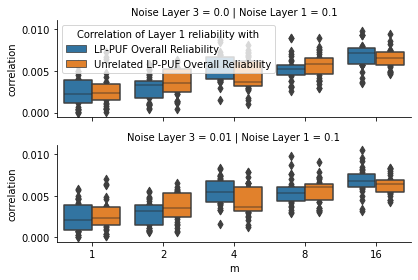

In [18]:
melted_data['Noise Layer 1'] = melted_data['noisiness_1']
melted_data['Noise Layer 3'] = melted_data['noisiness_2']

g = sns.catplot(
    data=melted_data,
    x='m',
    y='correlation',
    hue='Correlation of Layer 1 reliability with',
    row='Noise Layer 3',
    col='Noise Layer 1',
    kind='boxen',
    aspect=3/1,
    height=2,
    legend_out=False,
)
g.tight_layout()
g.savefig('figures/lppufv1-reliability-correlation-layer-1.pdf')

## Sanity Check: Reliability Correlation of Interpose PUFs with Top Layer

In [13]:
puf = pypuf.simulation.InterposePUF(n=64, k_up=1, k_down=8, seed=1, noisiness=.05)
pufa = pypuf.simulation.InterposePUF(n=64, k_up=1, k_down=8, seed=2, noisiness=.05)

r = 15
N = 100000

challenges = pypuf.io.random_inputs(n=64, N=N, seed=1)
r1 = np.average(puf.up.r_eval(r=r, challenges=challenges), axis=-1)
r2 = np.average(puf.r_eval(r=r, challenges=challenges), axis=-1)
r2a = np.average(pufa.r_eval(r=r, challenges=challenges), axis=-1)

In [14]:
sp.stats.pearsonr(r1[:, 0], r2[:, 0])[0], sp.stats.pearsonr(r1[:, 0], r2a[:, 0])[0]

(0.0015845569848167203, -0.00128801268202545)